<a href="https://colab.research.google.com/github/viriditass/Paper-Review/blob/main/Transformer_XL_Attentive_Language_Models_Beyond_a_Fixed_Length_Context.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Transformer-XL: Attentive Language Models Beyond a Fixed-Length Context**

논문 링크: https://arxiv.org/abs/1901.02860

XLNet 논문에서 Transformer-XL에 관한 언급이 있어서 찾아보게 되었다. 해당 논문은 기존 transformer의 한계점을 개선하고자 나온 논문이다.

**기존의 transformer는** input으로 사용되는 segment 안의 character들간의 dependency만 학습할 수 있고, **다른 segment 간의 dependency는 학습하지 못한다.**
뿐만아니라 이런 segment들은 sentense의 구분이나 의미적인 구분 없이 단순하게 단어의 갯수를 기준으로 분리가 되었기 때문에 처음 몇 개의 단어를 예측할 때 사용할 수 있는 정보가 별로 없다.

본 논문의 저자는 이 문제를 **context fragmentation**이라고 부른다.

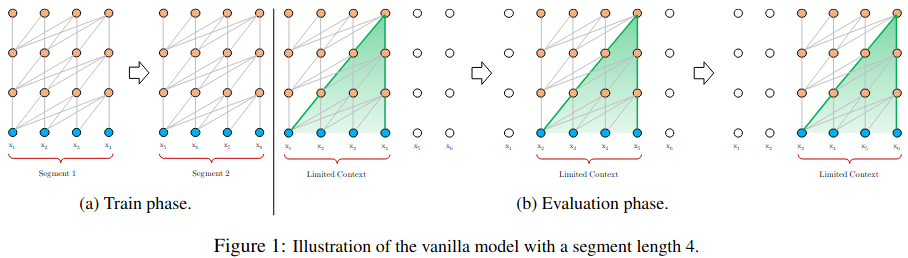

위에서 말한 **context fragmentation** 문제와 더불어 기존 방식은 학습이 끝나고 **prediction을 수행할 때 중복된 연산이 많다.**

왜냐하면 prediction 단계에서 한 segment를 이용해 segment의 맨 마지막 한 개의 위치에 올 token만을 predict하게 되기 때문이다.

이해를 돕기 위해 예시를 들자면, [x_1, x_2, x_3, ...]이 있을때, 
- x_t를 예측하려면 [x1, x2, .. x_t-1]을 이용해 예측하게 되고 
- x_t+1을 예측하려면 [x2, x3, ..., x_t]를 이용해 예측하게 되므로

**겹치는 token들을 다시 연산**하게 된다.

위의 그림 Figure 1의 (b) 부분을 보면 좀 더 쉽게 이해할 수 있다.

이러한 prediction 방법은 train때와 달리 context fragmentation 문제의 영향을 덜 받게 되지만, 그 만큼 연산량이 많아져서 속도가 느려지게 된다.

## **Transformer-XL**

따라서 본 논문은 이 문제를 해결하기 위해 **Transformer-XL**을 제안하게 된다. Transformer-XL은 **현재 segment를 처리할 때, 이전 segment를 처리하는데 계산됬던 hidden state들을 사용하는 recurrence를 추가**하였다. 또한, 이에 적합하게 **positional encoding을 변형**했다.

### **Segment-Level Recurrence with State Reuse**

방금 언급했듯이 recurrence 메커니즘을 도입하게 되는데, **학습시 이전 segment 처리할 때 계산된 hidden state를 사용**한다.

이렇게 이전 segment의 hidden state를 활용하면 이전보다 더 긴 long-term dependency를 학습할 수 있다.

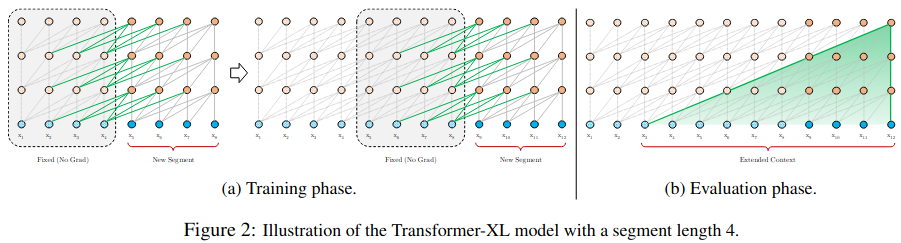

위의 그림 Figure 1의 (a) 부분을 보면 x_5 시점에서 다음 값을 예측할 때, (x_2, x_3, x_4)의 hidden state를 활용하는 것을 알 수 있다. 만일 이게 없었다면 단순 x_5의 정보만을 이용해 predict를 했을 것이다. 이처럼 Transformer-XL은 항상 max input 갯수만큼 predict에 정보를 줄 수 있다.

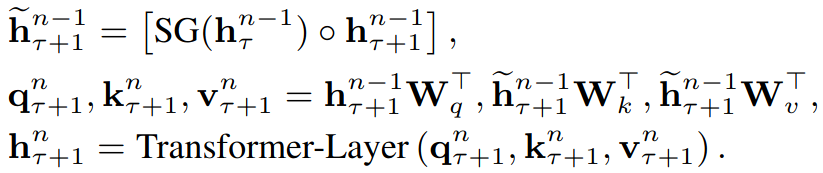

이런 학습 과정을 수식으로 나타내면 위의 식과 같다. 수식의 기호가 의미하는 것을 설명하자면,
- n = layer의 층 수
- h_T = 길이가 L인 input [x_1, x_2, ..., x_L]
- h_T+1 = h_T 뒤에 이어진 길이가 L인 input [x_L+1, x_L+2, ..., x_L+L]
- SG = stop-gradient
- [h_u ㅇ h_v] = 두 hidden state를 concatente 연산

수식을 보면 알 수 있듯이 self-attention의 key와 value를 계산할 때, 이전 segment의 hidden state와 현재 segment의 hidden state를 concat하여 얻은 vector를 이용한다.

이러한 recurrence 메커니즘은 segment 단위의 recurrence를 만들어낸다. 그래서 필요한 context가 두 개의 segment를 넘어 여러 segment에 전파될 수 있다.

RNN과의 차이점은 recurrence가 두 layer에 거쳐 만들어진다는 점이다. recurrence가 만들어질 때 layer 층이 하나 증가한다.(RNN에서의 recurrence는 같은 층에서 만들어진다.)

따라서 가장 긴 dependency 길이가 N x L(N: layer 수, L: segment 길이)이 된다. (**truncated BPTT**를 이용한 RNN과 비슷)

recurrence를 활용하면 evaluation(=prediction) 속도가 훨씬 빨라진다. 이전의 segment 계산 결과를 저장해놓고 사용하기 때문에 매번 다시 계산할 필요가 없다. (실제 실험에서 vanilla transformer보다 1800배 이상 빠른 속도를 보여줌)

### **Relative Positional Encodings**

그러나, Transformer에 recurrence 메커니즘을 추가하게 되면 **transformer 구조에 사용되는 position 정보를 어떻게 추가할 것인지에 대한 문제**가 생긴다.

**이전 segment에 사용된 position 정보가 현재 segment에도 변함없이 동일하게 적용**되기 때문에 h_T[1] (=이전 segment의 첫 번째 input)에 더해진 position 정보와 h_{T+1} (=현재 segment의 첫 번째 input)에 더해진 **position 정보가 같다**.

이 문제를 해결하기 위해 **기존의 "*absolute*" position이 아닌 "*relative*" position 정보를 주입**힌다. "absolute" postion 정보는 두 token 간의 attention을 계산할 때 활용된다.

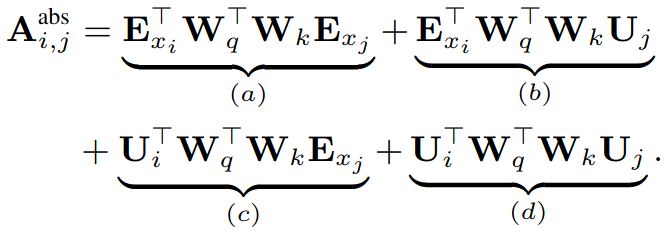

먼저, vanilla Transformer의 동일한 segment 내에서 Query q_i와 Key vector k_j는 위의 식과 같이 표현할 수 있다. (E는 token embedding이며 U는 position 정보이다.)

'absolute' position 정보가 두 수의 차이를 계산하기 위해 a=1, b=2 이렇게 값을 지정하고 그 값으로 차이를 계산하는 방식이라면, 'relative' position 정보는 두 수의 값과는 전혀 상관없이 차이값만 갖고 있다. (=즉, (a=3,b=4) 던지 (a=8,b=9)이던지 차이가 1인 것만 알려주면 됨)

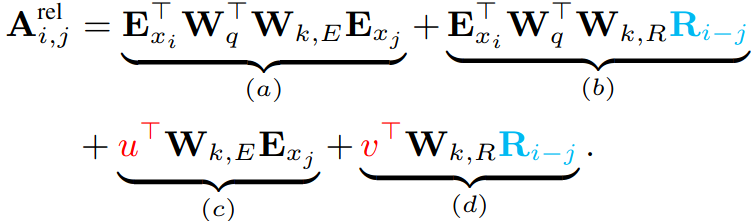

해당 방식을 이용한 attention을 수식으로 나타내면 위의 식과 같다.

위 식에서 R이 'relative' position 정보를 encoding한 matrix를 가르키며 기존에 쓰이던 U를 대체하고 있다. 또한, R은 **attention is all you need의 방식이 아닌 sinusoid encoding matrix를 그대로 사용**한다.

추가적으로 vector 형태의 u, v parameter가 도입이 됬는데, 두 vector는 query 단어의 position과는 상관 없이 같은 값을 갖는다. 절대 위치는 사용하지 않으며, 상대 위치는 R을 통해서 알 수 있기 때문에 굳이 U_i * W_q를 계산할 필요가 없다. 따라서 u, v로 대체됐다.

## **Experiments**

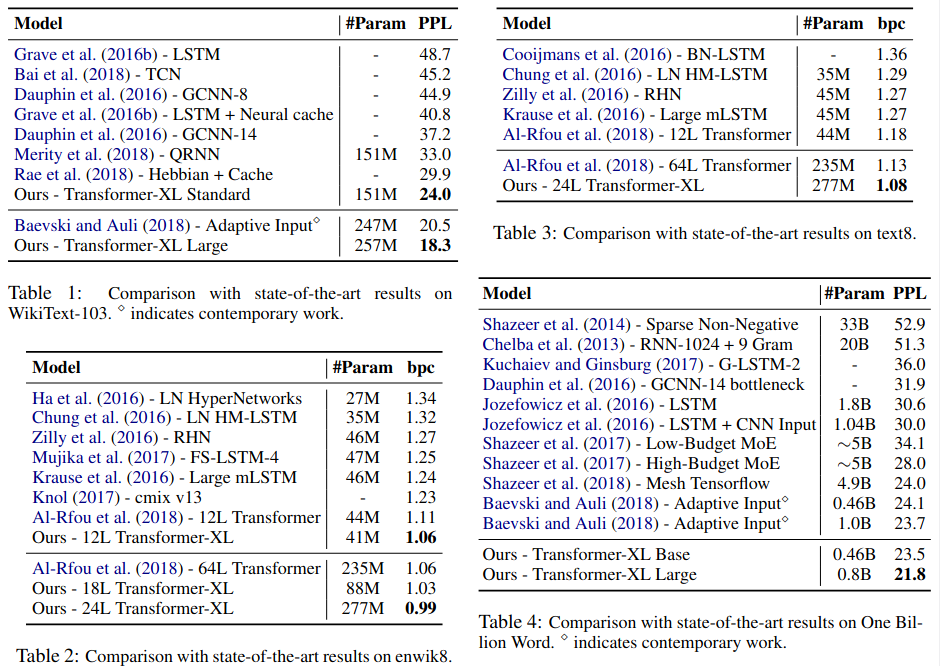